In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error

from warnings import filterwarnings
filterwarnings("ignore")
sns.set_style("darkgrid")  # 'white', 'dark', 'whitegrid', 'darkgrid', 'ticks'
# sns.set_theme(palette='mako')

In [6]:
cali_df_temp = fetch_california_housing(as_frame=True)

cali_housing_samples : pd.DataFrame = cali_df_temp['data']
cali_housing_targets : pd.DataFrame = cali_df_temp['target']

calif_df : pd.DataFrame= cali_df_temp.frame

#  <p align='center'> Cleaning the data </p>

* This dataset has outliers.
* We will show boxplots showing these outliers.
* Then we will show the boxplots after the replacing these outliers with median of their column

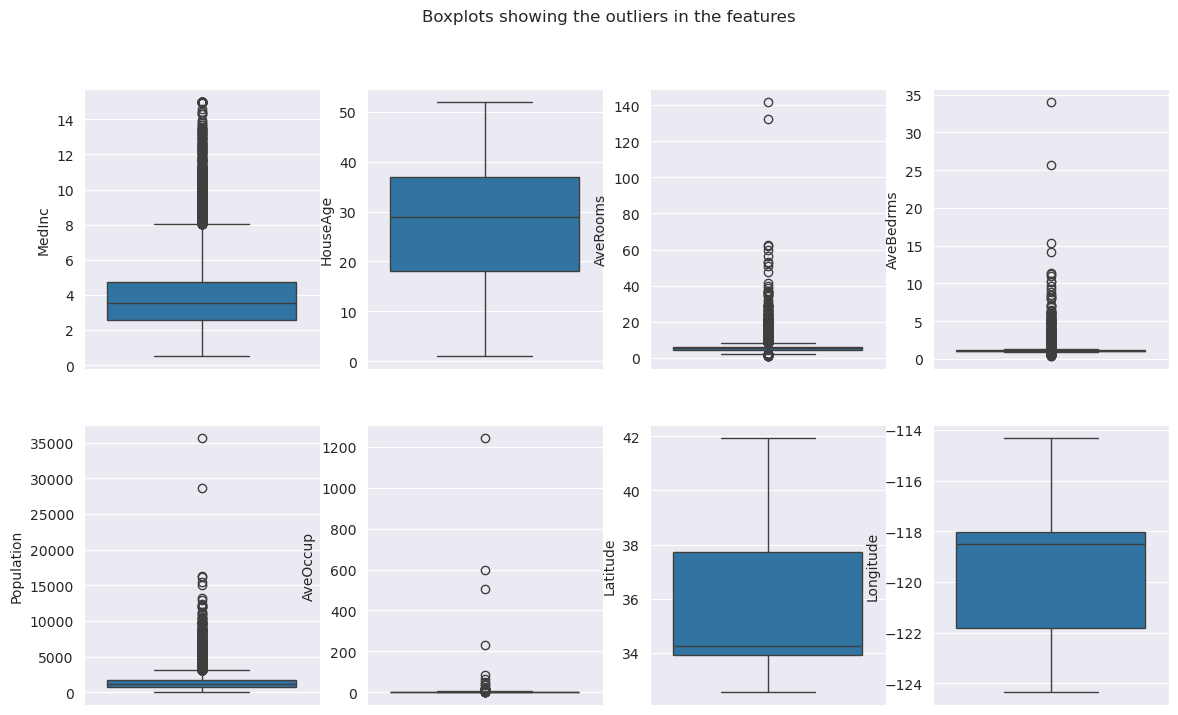

In [7]:
number_of_columns = cali_housing_samples.shape[1]
figure, axes = plt.subplots(nrows=2, ncols=number_of_columns//2, figsize=(14, 8))
figure.suptitle('Boxplots showing the outliers in the features')
axes = axes.flatten()

for index, column in zip(range(number_of_columns), cali_housing_samples.columns):
    sns.boxplot(cali_housing_samples[column], ax=axes[index])

In [8]:
features_with_outliers = ["MedInc", "AveRooms", "AveBedrms", "AveOccup", "Population"]

remove_outliers_copy = cali_housing_samples.copy()

def replace_outliers_with_median(df : pd.DataFrame, column : str) -> pd.DataFrame:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    median_value = df[column].median()
    
    # Replace outliers with median
    df.loc[df[column] < lower_bound, column] = median_value
    df.loc[df[column] > upper_bound, column] = median_value
    
    return df

# Example: apply to all numeric columns in California housing data
for col in remove_outliers_copy[features_with_outliers].select_dtypes(include='number').columns:
    remove_outliers_copy = replace_outliers_with_median(remove_outliers_copy, col)

# how many rows did we lose
number_of_rows_lost = cali_housing_samples.shape[0] - remove_outliers_copy.shape[0]
print(f'Number of lost rows: {number_of_rows_lost} row')
percentage_lost_rows = number_of_rows_lost / remove_outliers_copy.shape[0] * 100
print(f'percentage of lost rows: {percentage_lost_rows:.0f} %')

Number of lost rows: 0 row
percentage of lost rows: 0 %


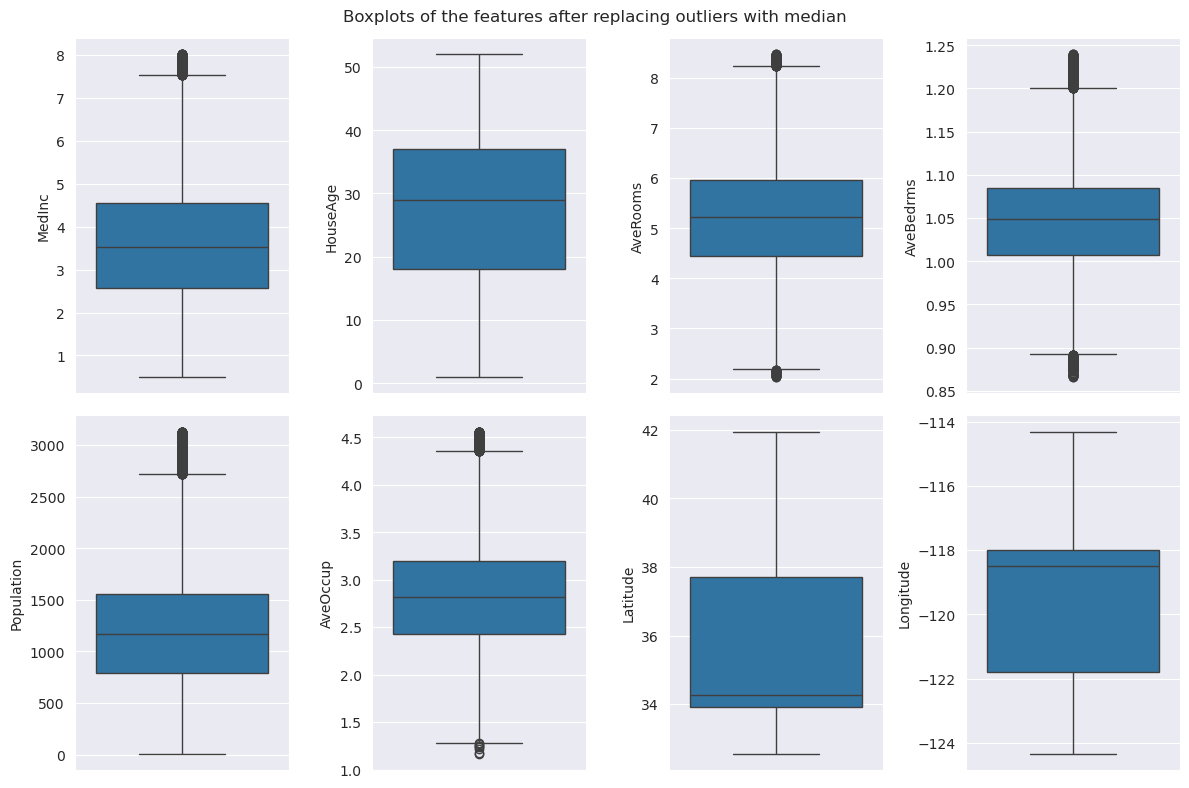

In [9]:
number_of_columns = remove_outliers_copy.shape[1]
figure, axes = plt.subplots(nrows=2, ncols=number_of_columns//2, figsize=(12, 8))
figure.suptitle('Boxplots of the features after replacing outliers with median')
axes = axes.flatten()

for index, column in zip(range(number_of_columns), remove_outliers_copy.columns):
    sns.boxplot(remove_outliers_copy[column], ax=axes[index])
figure.tight_layout()

This is a custom that's just a helper class.<br>
It doesn't do anything except group methods and print statements, to reduce writing the same code over and over again.<br>
I'll be running linear regression on the dataset, four different times after each feature engineering steps. So there will be a lot of repetition, and having this class, makes that easier.

In [10]:
class CustomLinearRegression:
    def __init__(self, features : pd.DataFrame = None, target: np.typing.NDArray = None):
        """
            A convenience wrapper class for performing Linear Regression with train-test split,
            evaluation metrics, coefficient extraction, and residual analysis plots.

            Parameters:
            -----------
            features : pd.DataFrame
                Input feature dataset used for training and testing the model.
            target : pd.Series or np.ndarray
                Target variable array or series corresponding to the features.

            Attributes:
            -----------
            X_train, X_test : pd.DataFrame
                Training and testing splits of the features.
            y_train, y_test : np.ndarray or pd.Series
                Training and testing splits of the target.
            lr : sklearn.linear_model.LinearRegression
                The fitted Linear Regression model.
            predictions : np.ndarray
                Predictions made on the test set.
            r_squared : float
                R² score on the test set.
            mse : float
                Mean Squared Error on the test set.
            rmse : float
                Root Mean Squared Error on the test set.

            Methods:
            --------
            fit_and_predict():
                Fits the linear regression model on the training data and generates predictions on the test set.
            weights_and_intercept() -> pd.DataFrame:
                Returns a DataFrame containing the model coefficients sorted by magnitude and the intercept.
            metrics() -> dict[str, str]:
                Returns R², MSE, and RMSE scores as formatted strings for the test set.
            get_predictions() -> np.ndarray:
                Returns the model predictions on the test set.
            check_overfit() -> dict[str, str]:
                Compares training and testing metrics to assess overfitting.
            get_residuals() -> np.ndarray:
                Returns residuals (actual - predicted) for the test set.
            plot_residuals(x_size=12, y_size=5):
                Plots a histogram of residuals with KDE and zero reference line.
            plot_residuals_vs_predictions(x_size=12, y_size=5):
                Plots residuals versus predicted values scatter plot with zero horizontal line.

            Usage:
            ------
            model = CustomLinearRegression(features_df, target_array)
            model.fit_and_predict()
            print(model.metrics())
            model.plot_residuals()
            model.plot_residuals_vs_predictions()
        """

        if features is None or target is None:
            raise Exception("you must pass a features and a target")
        
        # make sure it's a Pandas Series or Numpy NDArray
        if not (isinstance(target, pd.Series) or isinstance(target, np.ndarray)):
            raise TypeError("Target must be a 1D NumPy array or Pandas Series. DataFrame is not allowed.")
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            features,
            target,
            test_size=0.2,
            random_state=100
        )
        
        # sklearn expect the y_train and y_test arrays to be one dimensional
        self.y_train = np.ravel(self.y_train)
        self.y_test = np.ravel(self.y_test)

        self.lr : LinearRegression | None = None
        self.predictions : np.typing.NDArray | None = None
        self.r_squared : float = None
        self.mse : float | None= None
        self.rmse : float | None = None
    
    def fit_and_predict(self) -> None:
        self.lr = LinearRegression().fit(self.X_train, self.y_train)
        self.predictions = self.lr.predict(self.X_test)
        self.r_squared = r2_score(self.y_test, self.predictions)
        self.mse = mean_squared_error(self.y_test, self.predictions)
        self.rmse = root_mean_squared_error(self.y_test, self.predictions)

    def weights_and_intercept(self) -> pd.DataFrame:
        '''
            Returns a dataframe with the weights and intercept (with an empty row betwen for visual purposes)
        '''

        # confirm that the model fitted and predicted on the data first
        if self.lr is None:
            raise Exception("Model has not been fitted yet. Call fit_and_predict() first.")
        
        coefficients = self.lr.coef_ if self.lr.coef_.ndim == 1 else self.lr.coef_.flatten()
        df = pd.DataFrame(data={'Coefficients and Intercept': coefficients}, index=self.X_train.columns)
        df.sort_values(by='Coefficients and Intercept', ascending=False, inplace=True)
        df.loc[''] = ''  # to separate the weight from the weights visually
        df.loc['Intercept'] = self.lr.intercept_
        return df

    def metrics(self) -> dict[str, str]:
        # confirm that the model fitted and predicted on the data first
        if self.lr is None:
            raise Exception("Model has not been fitted yet. Call fit_and_predict() first.")
        
        return {
            'R2:': f'{self.r_squared:.2f}',
            'Mean Squared Error:': f'{self.mse:.2f}',
            'Root Mean Squared Error:': f'{self.rmse:.2f}',
        }
    
    def get_predictions(self) -> np.typing.NDArray:
        return self.predictions
    
    def check_overfit(self) -> dict[str, str]:
        '''
            Check on the R2 score and MSE in trainging and testing set.
            If the training R2 score is much higher in the training set,
                then the model has overfit the training set.
            If the MSE is much lower in the training set,
                then the model has overfit the training set.
        '''
        training_predictions = self.lr.predict(self.X_train)
        
        training_r2 = r2_score(self.y_train, training_predictions)
        training_mse = mean_squared_error(self.y_train, training_predictions)

        return {
            'Training R2:': f'{training_r2:.2f}',
            'Testing R2:': f'{self.r_squared:.2f}',
            'Training Mean Squared Error:': f'{training_mse:.2f}',
            'Testing Mean Squared Error:': f'{self.mse:.2f}',
        }
    
    def get_residuals(self) -> np.typing.NDArray:
        return np.ravel(self.y_test) - np.ravel(self.predictions)
    
    def plot_residuals(self, x_size = 12, y_size = 5):
        '''
            A histogram of the residuals checks if the residuals are normally distributed or not.
            In other words, the residuals of the model are randomally distributed
            This is an assumption of linear regression.

            It should show the residuals are centered on or around zero.
            This shows that the model is not consistently predicting over or under the true value.

            Skewed left            -> model is over-predicting
            Skewed right           -> model is under-predicting
            Long tails             -> outliers are present
            Shifted away from zero -> model shows a systematic bias in its predictions
        '''
        plt.figure(figsize=(x_size, y_size))
        plt.title('Residuals Plot')
        plt.xlabel('Residuals')
        plt.ylabel('Count')
        sns.histplot(self.get_residuals(), kde=True)
        plt.axvline(x=0, color='red', linestyle='--')
        plt.show()

    def plot_residuals_vs_predictions(self, x_size=12, y_size=5):
        '''
        The residuals vs predictions show if the linear regression assumptions are valid:
            1. Linearity
            2. Homoscedasticity
            3. Independence of errors
             
        | Pattern                                                   | What It Means                                         | Fix Suggestion                                     |
        | ----------------------------------------------------------| ------------------------------------------------------| -------------------------------------------------- |
        | U-shaped / curve                                          | Nonlinearity — model missing curved relationship      | Add polynomial or nonlinear features               |
        | Funnel shape (residuals spread increases with prediction) | Heteroscedasticity — error variance changes           | Log-transform target or use Weighted Least Squares |
        | Sloped line                                               | Model is (biased) — consistently over/underpredicts   | Add missing feature or fix target                  |
        | Clusters or structure                                     | Model missing interaction or grouping effects         | Add interaction terms, segment model               |
        | Isolated large residuals                                  | Outliers                                              | Investigate or remove/cap                          |
        '''
        plt.figure(figsize=(x_size, y_size))
        sns.scatterplot(x=self.predictions, y=self.get_residuals(), alpha=0.6)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.title("Residuals vs Predicted Values")
        plt.show()

#  <center> Important Note on feature engineering </center>

After feature engineering, I will be removing original features.<br>
The new features `should` be more informative and linear regression is sensitive to multicollinearity.<br>
Multicollinearity will be produced after each step of feature engineering<br>

If I was using a tree based model, I would've kept the original features, because they aren't sensitive to multicollinearity.

# <p align='center'> Base correlation matrix </p>

Text(0.5, 1.0, 'Correlation matrix before any transformations')

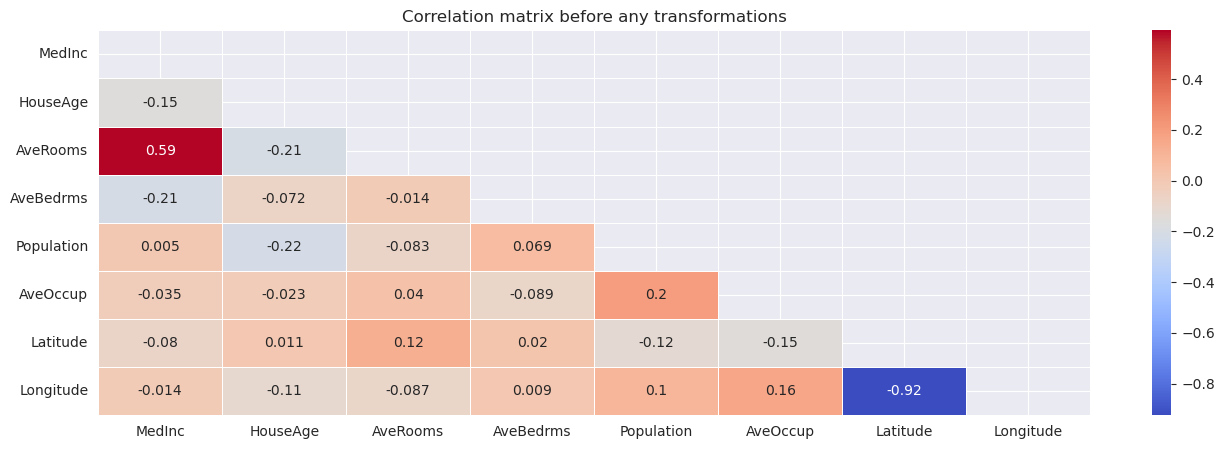

In [11]:
correlation_matrix_base = remove_outliers_copy.corr()
mask = np.triu(np.ones_like(correlation_matrix_base))
plt.figure(figsize=(16, 5))
sns.heatmap(correlation_matrix_base, cmap='coolwarm', linewidths=0.5, annot=True, mask=mask)
plt.title('Correlation matrix before any transformations')

<Axes: title={'center': 'Correlation between the base features and the target'}>

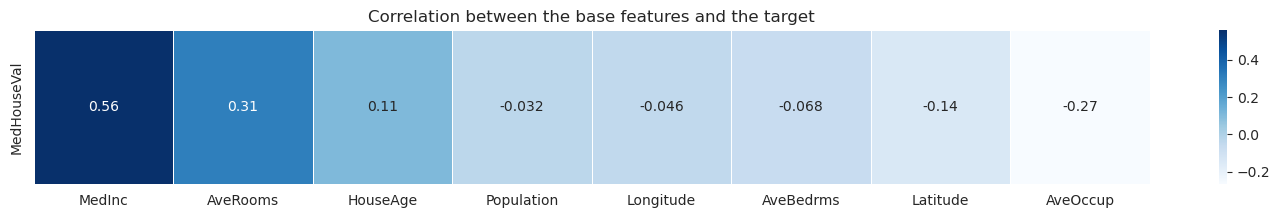

In [12]:
plt.figure(figsize=(18, 2))
plt.title('Correlation between the base features and the target')

full_df = pd.DataFrame(remove_outliers_copy)
full_df['MedHouseVal'] = cali_housing_targets

correlation_with_target = pd.DataFrame(full_df.corr()['MedHouseVal'])
correlation_with_target.drop('MedHouseVal', inplace=True, axis=0)

sns.heatmap(correlation_with_target.T.sort_values(by='MedHouseVal', ascending=False, axis=1), annot=True, cmap='Blues', linewidths=0.5)

# <p align='center'> Linear Regression #1: Before any feature engineering (as base case) </p>

In [13]:
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(cali_housing_samples, cali_housing_targets, test_size=0.2, random_state=100)

# # fit and predict
# lr_base = LinearRegression().fit(X_train, y_train)
# base_predictions = lr_base.predict(X_test)

# # print the weights and intercept
# print('\nWeights of base linear regression:\n')
# for feature, weight in zip(X_train.columns, lr_base.coef_):
#     print(f'{feature}: {weight:.2f}')
# print(f'\nIntercept: {lr_base.intercept_}')

# # error metrics
# r_squared_base = r2_score(y_true=y_test, y_pred=base_predictions)
# mse_base = mean_squared_error(y_true=y_test, y_pred=base_predictions)
# rmse_base = root_mean_squared_error(y_true = y_test, y_pred = base_predictions)
# mae_base = mean_absolute_error(y_true = y_test, y_pred = base_predictions)

# print(f'\n\nR2 score: {r_squared_base:.2f}')
# print(f'Mean squared error: {mse_base:.2f}')
# print(f'Root mean square error: {rmse_base:.2f}')
# print(f'Mean Absolute error: {mae_base:.2f}')

clr_base = CustomLinearRegression(features=remove_outliers_copy, target=cali_housing_targets)
clr_base.fit_and_predict()
print(clr_base.weights_and_intercept())
print('\n', clr_base.metrics())

           Coefficients and Intercept
AveBedrms                    0.465258
MedInc                        0.29809
AveRooms                     0.165761
HouseAge                     0.010076
Population                   0.000037
AveOccup                    -0.488924
Longitude                   -0.533685
Latitude                    -0.554022
                                     
Intercept                  -43.393011

 {'R2:': '0.54', 'Mean Squared Error:': '0.62', 'Root Mean Squared Error:': '0.79'}


# <p align='center'>NonLinear Transformations (Handles Skew and Variance) </p>

We will apply nonlinear transformation on the following features:
1. Median Income (MedInc)
2. Population (Population)

In [14]:
non_linear_copy = remove_outliers_copy.copy()
non_linear_copy["Log_MedInc"] = np.log1p(cali_housing_samples["MedInc"])   # Handles skew
non_linear_copy["Log_Population"] = np.log1p(cali_housing_samples["Population"])  # Handles skew

non_linear_copy = non_linear_copy.drop(['MedInc', 'Population'], axis=1)

Let's see what this nonlinear transform did to the skew of the `MedInc` and `Population` features

1.6466567021344465
0.22608313067130548
4.93585822672712
-1.0440866961519721


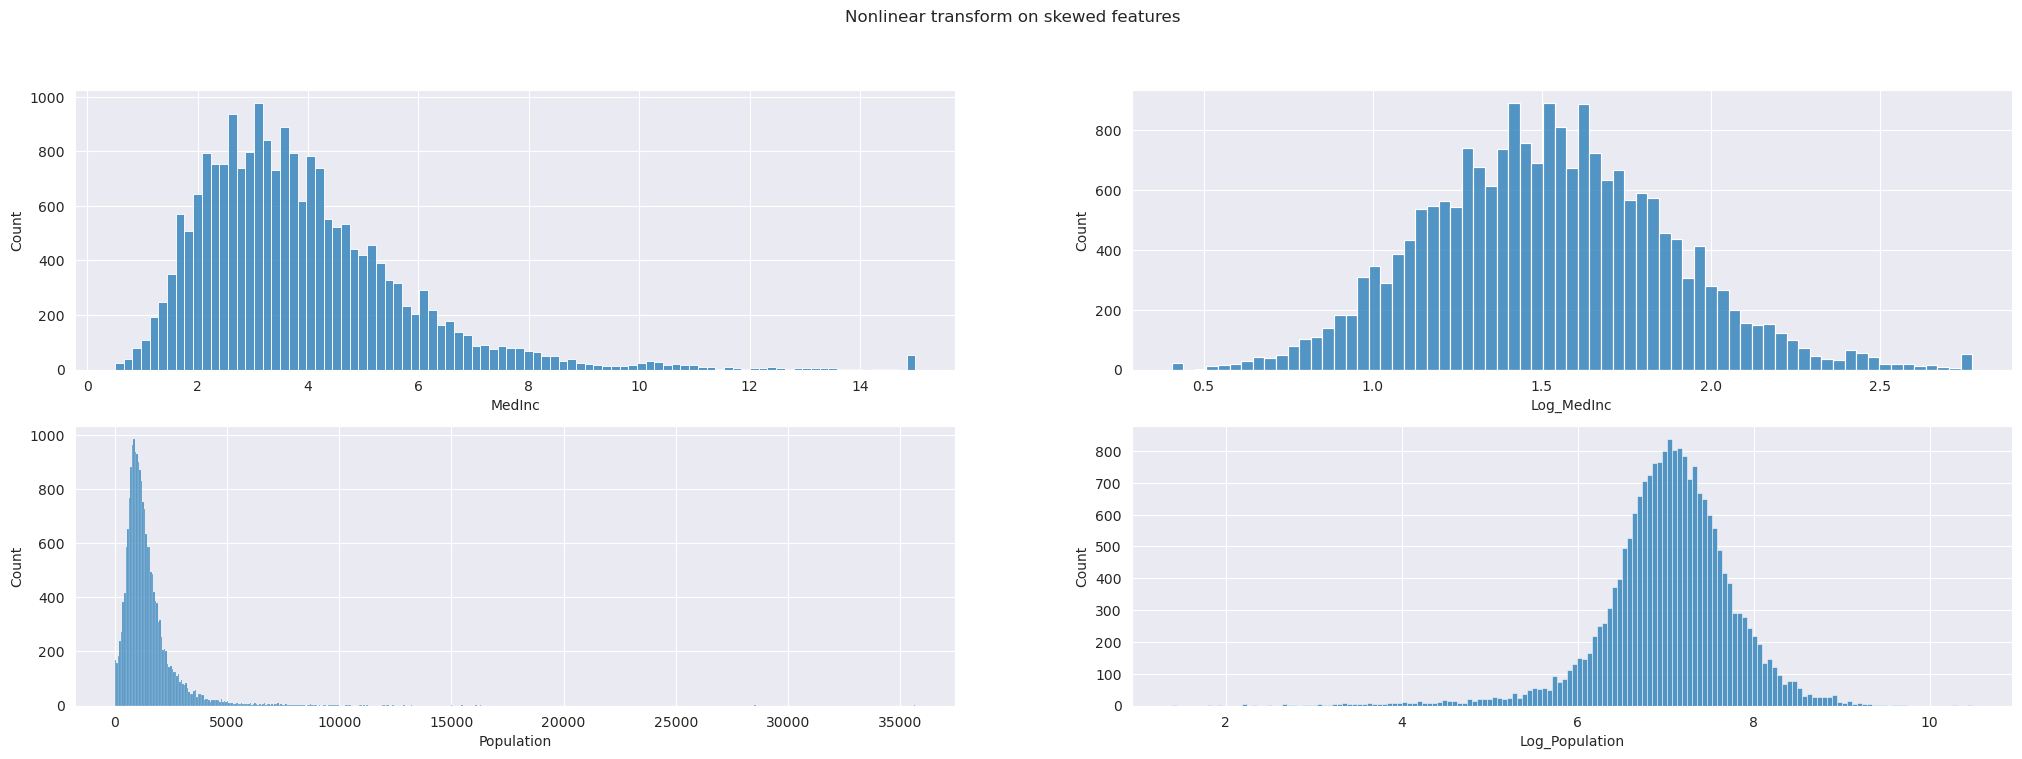

In [ ]:
sns.set_style("darkgrid")  # 'white', 'dark', 'whitegrid', 'darkgrid', 'ticks'

figure, axes = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(25, 8)
figure.suptitle('Nonlinear transform on skewed features')

sns.histplot(x=cali_housing_samples['MedInc'], ax=axes[0, 0])

sns.histplot(x=non_linear_copy['Log_MedInc'], ax=axes[0, 1])

sns.histplot(x=cali_housing_samples['Population'], ax=axes[1, 0])

sns.histplot(x=non_linear_copy['Log_Population'], ax=axes[1, 1])

Note below that `AveBedrms` and `AveRooms` are also both skewed, but we did not apply non-linear transformations on them.<br>
This is because `AveBedrms` is a subset of `AveRooms`. So nonlinear transforming them, won't affect this inherent relationship.<br>
Also, the raw value of `AveBedrms` is not as valuable as it's proportion in relation to `AveRooms`

<Axes: xlabel='AveRooms', ylabel='Count'>

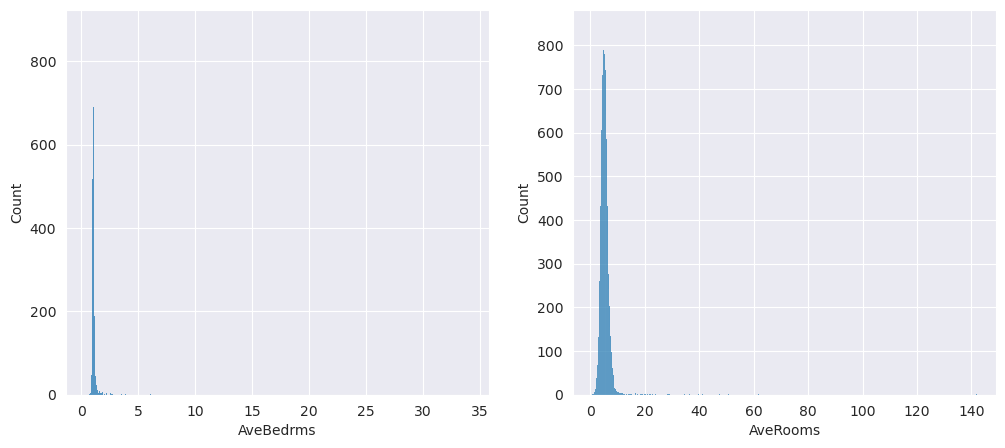

In [16]:
figure, axes = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(12, 5)
sns.histplot(x=cali_housing_samples['AveBedrms'], ax=axes[0])
sns.histplot(x=cali_housing_samples['AveRooms'], ax=axes[1])

# <p align='center'> Correlation matrix after nonlinear transformation </p>

<Axes: title={'center': 'Correlation matrix after applying nonlinear transformation'}>

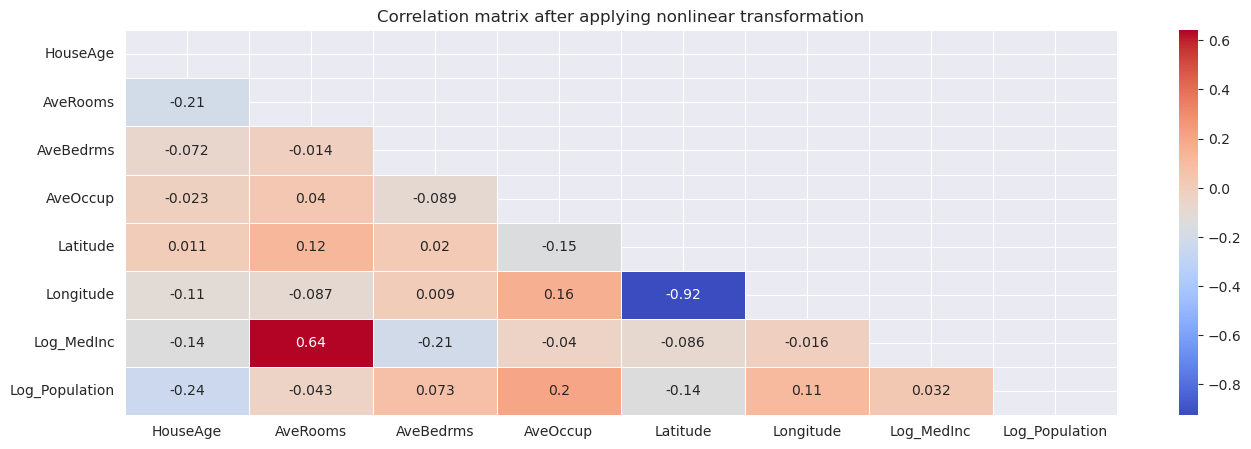

In [17]:
plt.figure(figsize=(16, 5))
plt.title('Correlation matrix after applying nonlinear transformation')

correlation_matrix_non_linear = non_linear_copy.corr()
mask = np.triu(np.ones_like(correlation_matrix_non_linear))
sns.heatmap(correlation_matrix_non_linear, cmap='coolwarm', linewidths=0.5, annot=True, mask=mask)

<Axes: title={'center': 'Correlation between the features and the target (after nonlinear transformation)'}>

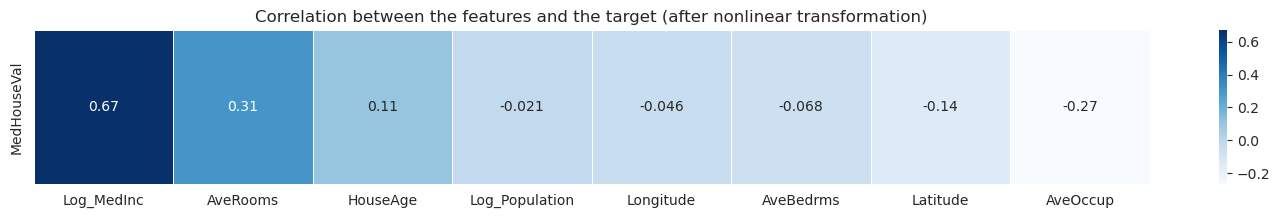

In [18]:
plt.figure(figsize=(18, 2))
plt.title('Correlation between the features and the target (after nonlinear transformation)')

full_df = pd.DataFrame(non_linear_copy)
full_df['MedHouseVal'] = cali_housing_targets

correlation_with_target = pd.DataFrame(full_df.corr()['MedHouseVal'])  # This shows MedHouseVal correlation with itself. It's always 1
correlation_with_target.drop('MedHouseVal', inplace=True, axis=0)
sns.heatmap(correlation_with_target.T.sort_values(by='MedHouseVal', ascending=False, axis=1), annot=True, cmap='Blues', linewidths=0.5)

# <p align='center'> Linear Regression #2: After nonlinear transformation `MedInc` and `Population` features </p>

In [19]:
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(non_linear_copy, cali_housing_targets, test_size=0.2, random_state=100)

# # fit and predict
# lr_non_linear = LinearRegression().fit(X_train, y_train)
# non_linear_predictions = lr_non_linear.predict(X_test)

# # print the weights and intercept
# print('\nWeights of base linear regression:\n')
# for feature, weight in zip(X_train.columns, lr_non_linear.coef_):
#     print(f'{feature}: {weight:.2f}')
# print(f'\nIntercept: {lr_non_linear.intercept_}')

# # error metrics
# r_squared_non_linear = r2_score(y_true=y_test, y_pred=non_linear_predictions)
# mse_non_linear = mean_squared_error(y_true=y_test, y_pred=non_linear_predictions)
# rmse_non_linear = root_mean_squared_error(y_true = y_test, y_pred = non_linear_predictions)
# mae_non_linear = mean_absolute_error(y_true = y_test, y_pred = non_linear_predictions)

# print(f'\n\nR2 score: {r_squared_non_linear:.2f}')
# print(f'Mean squared error: {mse_non_linear:.2f}')
# print(f'Root mean square error: {rmse_non_linear:.2f}')
# print(f'Mean Absolute error: {mae_non_linear:.2f}')

clr_non_linear_transformation = CustomLinearRegression(non_linear_copy, cali_housing_targets)
clr_non_linear_transformation.fit_and_predict()

# for key, value in clr.check_overfit().items():
#     print(key, value)
print(clr_non_linear_transformation.weights_and_intercept())
print('\n', clr_non_linear_transformation.metrics())

               Coefficients and Intercept
Log_MedInc                       2.020524
AveBedrms                         1.35121
HouseAge                         0.010847
Log_Population                  -0.002125
AveRooms                        -0.026697
Longitude                        -0.41459
Latitude                        -0.425401
AveOccup                        -0.434556
                                         
Intercept                      -35.747877

 {'R2:': '0.65', 'Mean Squared Error:': '0.48', 'Root Mean Squared Error:': '0.69'}


# <p align='center'> Ratio features </p>

We add news features that are ratios of the following feature combinations:
1. `AveBedrms` and `AveRooms` to get BedPerRoom
2. `AveRooms` and `Population` to get RoomPerPerson
3. `Population` and `AveOccup` to get NumberOfHouseholds
4. `MedInc` and `AveRooms` to get IncomePerRoom

In [20]:
print('Lets remind ourselves of the columns in the feature set so far:\n')
for index, column in enumerate(cali_housing_samples.columns):
    print(f'{index}) {column}')

Lets remind ourselves of the columns in the feature set so far:

0) MedInc
1) HouseAge
2) AveRooms
3) AveBedrms
4) Population
5) AveOccup
6) Latitude
7) Longitude


In [21]:
ratio_nonlinear_copy = non_linear_copy.copy()
ratio_nonlinear_copy['BedPerRoom'] = cali_housing_samples['AveBedrms'] / cali_housing_samples['AveRooms']
ratio_nonlinear_copy['BedPerPerson'] = cali_housing_samples['AveRooms'] / cali_housing_samples['AveOccup']
ratio_nonlinear_copy['NumberOfHouseholds'] = cali_housing_samples['Population'] / cali_housing_samples['AveOccup']
ratio_nonlinear_copy['IncomePerRoom'] = cali_housing_samples['MedInc'] / cali_housing_samples['AveRooms']
ratio_nonlinear_copy = ratio_nonlinear_copy.drop(['AveBedrms', 'AveRooms', 'AveOccup'], axis=1)
print(ratio_nonlinear_copy.columns)

Index(['HouseAge', 'Latitude', 'Longitude', 'Log_MedInc', 'Log_Population',
       'BedPerRoom', 'BedPerPerson', 'NumberOfHouseholds', 'IncomePerRoom'],
      dtype='object')


# <p align='center'> Correlation matrix after nonlinear transformation and ratio </p>

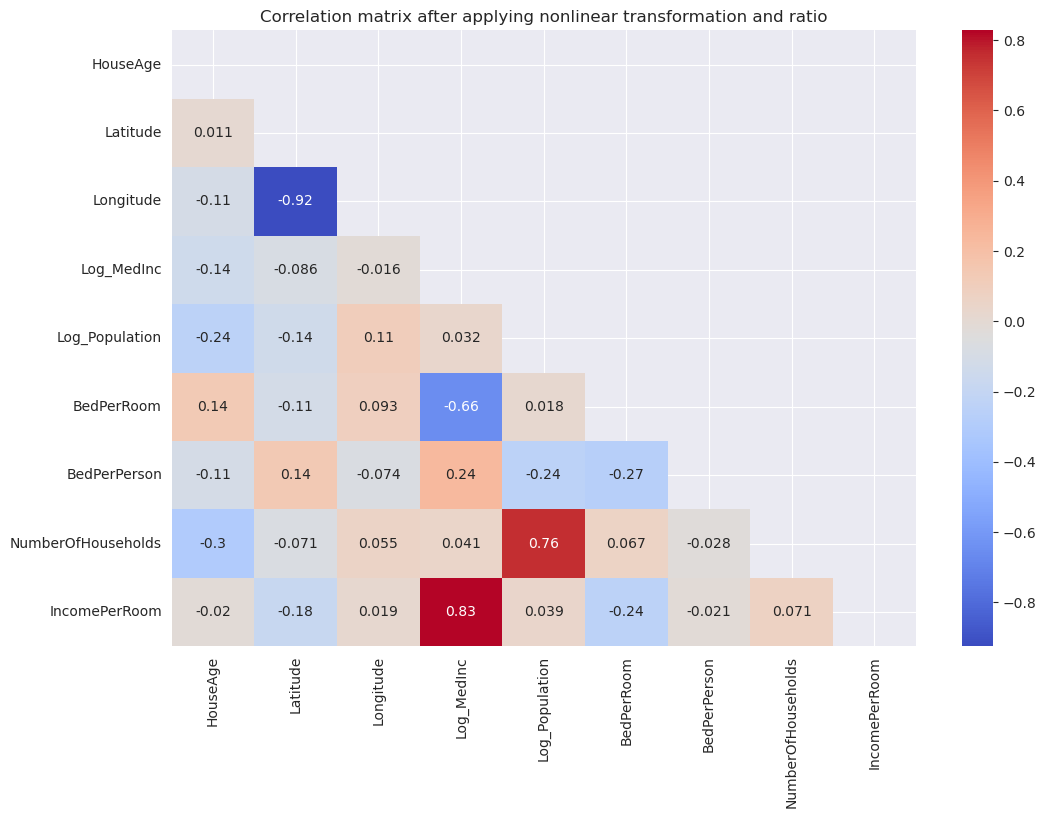

In [22]:
correlation_matrix_ratio = ratio_nonlinear_copy.corr()
mask=np.triu(np.ones_like(correlation_matrix_ratio))

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_ratio, cmap='coolwarm', annot=True, mask=mask)
plt.title('Correlation matrix after applying nonlinear transformation and ratio');

<Axes: title={'center': 'Correlation between the features and the target\n(after nonlinear transformation and ratio)'}>

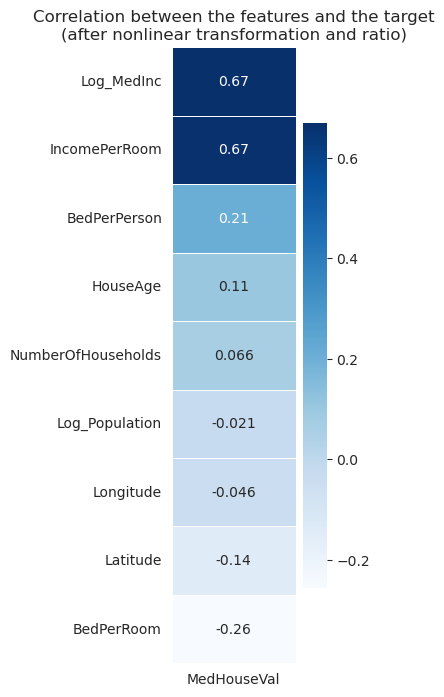

In [23]:
plt.figure(figsize=(2, 8))
plt.title('Correlation between the features and the target\n(after nonlinear transformation and ratio)')

full_df = pd.DataFrame(ratio_nonlinear_copy)
full_df['MedHouseVal'] = cali_housing_targets

correlation_with_target = pd.DataFrame(full_df.corr()['MedHouseVal'])
correlation_with_target.drop('MedHouseVal', inplace=True, axis=0)

sns.heatmap(correlation_with_target.sort_values(by='MedHouseVal', ascending=False, axis=0), annot=True, cmap='Blues', linewidths=0.5)

#  <p align='center'> Linear Regression #3<br>After nonlinear transformation and ratio </p>


In [24]:
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(ratio_nonlinear_copy, cali_housing_targets, test_size=0.2, random_state=100, shuffle=True)

# # fit and predict
# lr_non_linear_and_ratio = LinearRegression().fit(X_train, y_train)
# non_linear_and_ratio_predictions = lr_non_linear_and_ratio.predict(X_test)

# # print the result
# print('Weights of each column are:')
# for column, weight  in zip(X_train.columns, lr_non_linear_and_ratio.coef_):
#     print(f'\t{column}:  {weight:.2f}')
# print(f'\nintercept: {lr_non_linear_and_ratio.intercept_:.2f}')

# # error metrics
# r_squared_non_linear_ratio = r2_score(y_true=y_test, y_pred=non_linear_and_ratio_predictions)
# mse_non_linear_ratio = mean_squared_error(y_true=y_test, y_pred=non_linear_and_ratio_predictions)
# rmse_non_linear_ratio = root_mean_squared_error(y_true = y_test, y_pred = non_linear_and_ratio_predictions)
# mae_non_linear_ratio = mean_absolute_error(y_true = y_test, y_pred = non_linear_and_ratio_predictions)

# print(f'\n\nR2 score: {r_squared_non_linear_ratio:.2f}')
# print(f'Mean squared error: {mse_non_linear_ratio:.2f}')
# print(f'Root mean square error: {rmse_non_linear_ratio:.2f}')
# print(f'Mean Absolute error: {mae_non_linear_ratio:.2f}')

clr_non_linear_transformation_and_ratio = CustomLinearRegression(ratio_nonlinear_copy, cali_housing_targets)
clr_non_linear_transformation_and_ratio.fit_and_predict()
# for key, value in clr.check_overfit().items():
#     print(key, value)
print(clr_non_linear_transformation_and_ratio.weights_and_intercept())
print('\n', clr_non_linear_transformation_and_ratio.metrics())

                   Coefficients and Intercept
BedPerRoom                           3.832777
Log_MedInc                           2.139876
BedPerPerson                         0.165309
IncomePerRoom                         0.15455
HouseAge                             0.012246
NumberOfHouseholds                   0.000376
Log_Population                      -0.150023
Latitude                            -0.405572
Longitude                           -0.414676
                                             
Intercept                          -37.045561

 {'R2:': '0.63', 'Mean Squared Error:': '0.50', 'Root Mean Squared Error:': '0.71'}


#  <p align='center'> Adding a geospatial feature</p>
#### <p align='center'> By converting Latitude and Longitude to distance to Malilbu </p>

In [25]:
print('Features so far:')
ratio_nonlinear_copy.columns

Features so far:


Index(['HouseAge', 'Latitude', 'Longitude', 'Log_MedInc', 'Log_Population',
       'BedPerRoom', 'BedPerPerson', 'NumberOfHouseholds', 'IncomePerRoom'],
      dtype='object')

* Haversine_distance is just a function to called the distance between two (lat, lon) points

In [26]:
# Malibu coordinates
malibu_lat = 34.0259
malibu_lon = -118.7798

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    radius_earth_km = 6371  # Earth radius in kilometers
    return radius_earth_km * c



# Assuming cali_housing_samples has 'Latitude' and 'Longitude' columns
distances = haversine_distance(cali_housing_samples['Latitude'], cali_housing_samples['Longitude'], malibu_lat, malibu_lon)

# Show first 10 distances
print(type(distances))

<class 'pandas.core.series.Series'>


In [27]:
ratio_nonlinear_geospatial_copy = ratio_nonlinear_copy.copy()
ratio_nonlinear_geospatial_copy['DistanceToMalibu'] = distances
ratio_nonlinear_geospatial_copy = ratio_nonlinear_geospatial_copy.drop(['Longitude', 'Latitude'], axis=1)
ratio_nonlinear_geospatial_copy.head()

,HouseAge,Log_MedInc,Log_Population,BedPerRoom,BedPerPerson,NumberOfHouseholds,IncomePerRoom,DistanceToMalibu
0,41.0,2.232720,5.777652,0.146591,2.732919,126.0,1.192017,529.154374
1,21.0,2.230165,7.784057,0.155797,2.956685,1138.0,1.330750,526.849894
2,52.0,2.111110,6.208590,0.129516,2.957661,177.0,0.875637,527.023571
3,52.0,1.893579,6.326149,0.184458,2.283154,219.0,0.970046,527.555606
4,52.0,1.578195,6.338594,0.172096,2.879646,259.0,0.612272,527.555606


<Axes: title={'center': 'Correlation after nonlinear transformation, ratio, and geospatial engineering'}>

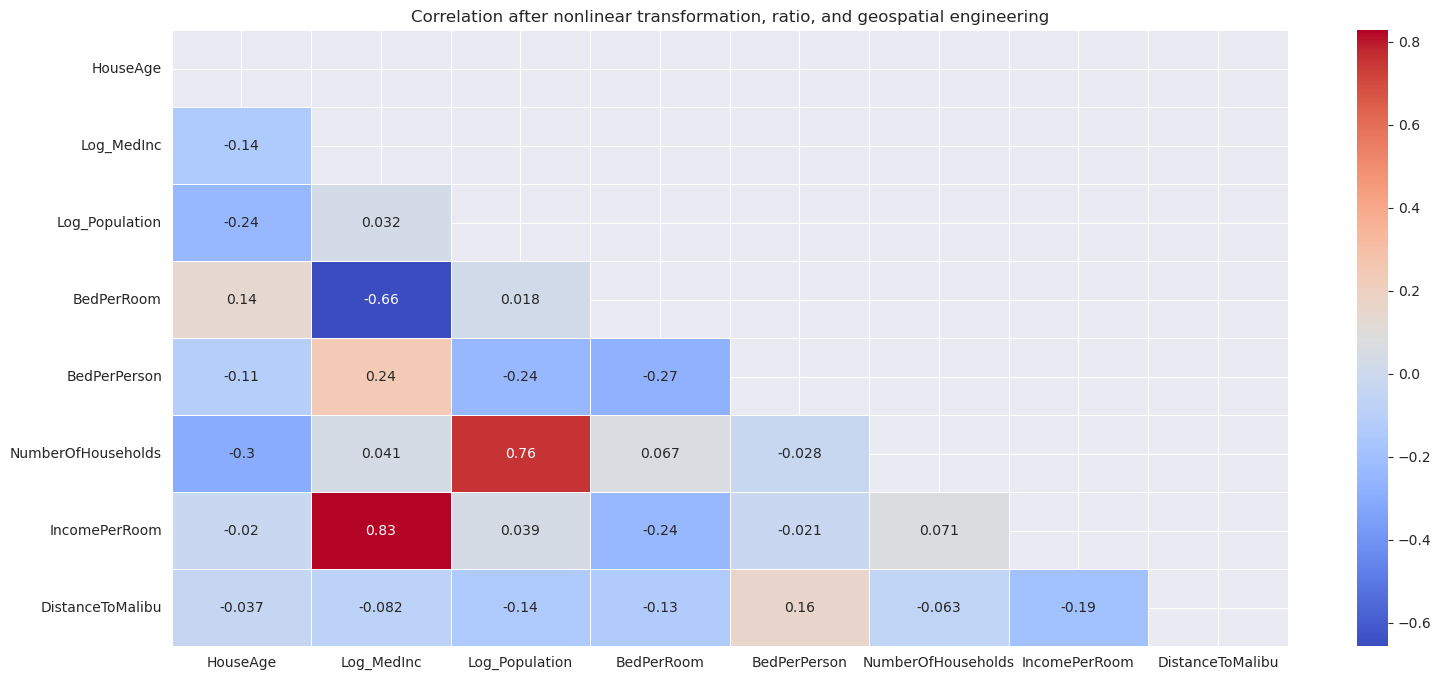

In [28]:
plt.figure(figsize=(18, 8))
plt.title('Correlation after nonlinear transformation, ratio, and geospatial engineering')

correlation_matrix_geospatial = ratio_nonlinear_geospatial_copy.corr()
mask = np.triu(np.ones_like(correlation_matrix_geospatial))

sns.heatmap(correlation_matrix_geospatial, cmap='coolwarm', annot=True, mask=mask, linewidths=0.5)

<Axes: title={'center': 'Correlation between the features and the target\n(After nonlinear transformation, ratio, and geospatial)'}>

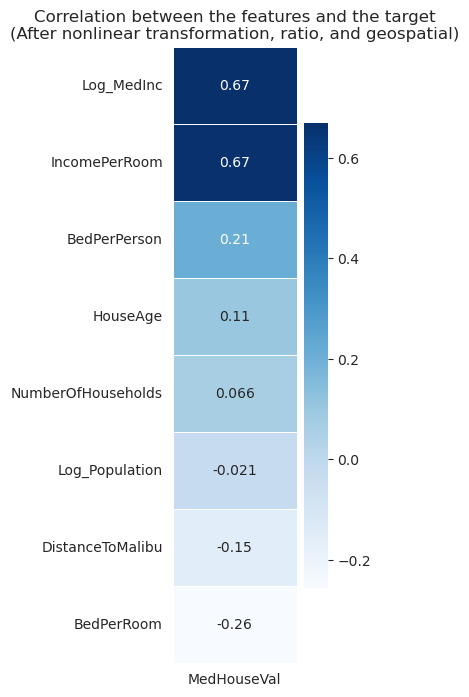

In [29]:
plt.figure(figsize=(2, 8))
plt.title('Correlation between the features and the target\n(After nonlinear transformation, ratio, and geospatial)')

full_df = pd.DataFrame(ratio_nonlinear_geospatial_copy)
full_df['MedHouseVal'] = cali_housing_targets

correlation_with_target = pd.DataFrame(full_df.corr()['MedHouseVal'])
correlation_with_target.drop('MedHouseVal', inplace=True, axis=0)  # correlation between `MedHouseVal` and itself. Always 1

sns.heatmap(correlation_with_target.sort_values(by='MedHouseVal', ascending=False, axis=0), annot=True, cmap='Blues', linewidths=0.5)

#  <p align='center'> Linear Regression #4<br>After nonlinear transformation, ratio, and geospatial engineering</p>

In [30]:
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(ratio_nonlinear_geospatial_copy, cali_housing_targets, test_size=0.2, random_state=100, shuffle=True)

# # scale the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


# # fit and predict
# lr_non_linear_and_ratio_geospatial = LinearRegression().fit(X_train_scaled, y_train)
# non_linear_and_ratio_and_geospatial_predictions = lr_non_linear_and_ratio_geospatial.predict(X_test_scaled)

# # print the weights and intercept
# print('Weights of each column are:')
# for column, weight  in zip(X_train.columns, lr_non_linear_and_ratio_geospatial.coef_):
#     print(f'\t{column}:  {weight:.2f}')

# print(f'\nintercept: {lr_non_linear_and_ratio_geospatial.intercept_}')

# # error metrics
# r_squared_non_linear_ratio_geospatial = r2_score(y_test, non_linear_and_ratio_and_geospatial_predictions)
# mse_non_linear_ratio_geospatial = mean_squared_error(y_test, non_linear_and_ratio_and_geospatial_predictions)
# rmse_non_linear_ratio_geospatial = root_mean_squared_error(y_test, non_linear_and_ratio_and_geospatial_predictions)
# mae_non_linear_ratio_geospatial = mean_absolute_error(y_test, non_linear_and_ratio_and_geospatial_predictions)

# print(f'\n\nR2 score: {r_squared_non_linear_ratio_geospatial:.2f}')
# print(f'Mean squared error: {mse_non_linear_ratio_geospatial:.2f}')
# print(f'Root mean square error: {rmse_non_linear_ratio_geospatial:.2f}')
# print(f'Mean Absolute error: {mae_non_linear_ratio_geospatial:.2f}')

clr_non_linear_transformation_and_ratio_geo_spatial = CustomLinearRegression(ratio_nonlinear_geospatial_copy, cali_housing_targets)
clr_non_linear_transformation_and_ratio_geo_spatial.fit_and_predict()
print(clr_non_linear_transformation_and_ratio_geo_spatial.weights_and_intercept())
clr_non_linear_transformation_and_ratio_geo_spatial.metrics()


                   Coefficients and Intercept
BedPerRoom                           4.793723
Log_MedInc                           2.340756
IncomePerRoom                        0.474807
BedPerPerson                          0.13189
HouseAge                             0.018982
NumberOfHouseholds                   0.000418
DistanceToMalibu                    -0.000281
Log_Population                      -0.133787
                                             
Intercept                           -2.835867


{'R2:': '0.58',
 'Mean Squared Error:': '0.57',
 'Root Mean Squared Error:': '0.75'}

#  <p align='center'> Summary </p>

Let's see all the R2 scores, Mean Squared Errors, and Root Mean Squared Errors, put together

In [31]:
df = pd.DataFrame(index=['R2', 'Mean Squared Error', 'Root Mean Squared Error'])
df['Base'] = clr_base.metrics().values()
df['NonLinear'] = clr_non_linear_transformation.metrics().values()
df['NonLinear_Ratio'] = clr_non_linear_transformation_and_ratio.metrics().values()
df['NonLinear_Ratio_Geospatial'] = clr_non_linear_transformation_and_ratio_geo_spatial.metrics().values()
df

,Base,NonLinear,NonLinear_Ratio,NonLinear_Ratio_Geospatial
R2,0.54,0.65,0.63,0.58
Mean Squared Error,0.62,0.48,0.50,0.57
Root Mean Squared Error,0.79,0.69,0.71,0.75


We see that the our linear regression model, performed best when we performed nonlinear transformations only
* NonLinear Transformations:
    * MedInc -> Log_MedInc.
    * Population -> Log_Population.
<br><br>
* Adding nonlinear transformations clearly improved performance significantly.
* Adding ratios slightly hurt performance (likely added noise or multicollinearity).
* Adding geospatial features further hurt performance — possibly due to:
    - Poor correlation with target
    - Redundancy with latitude/longitude
    - Overfitting or scale mismatch

---
---
---

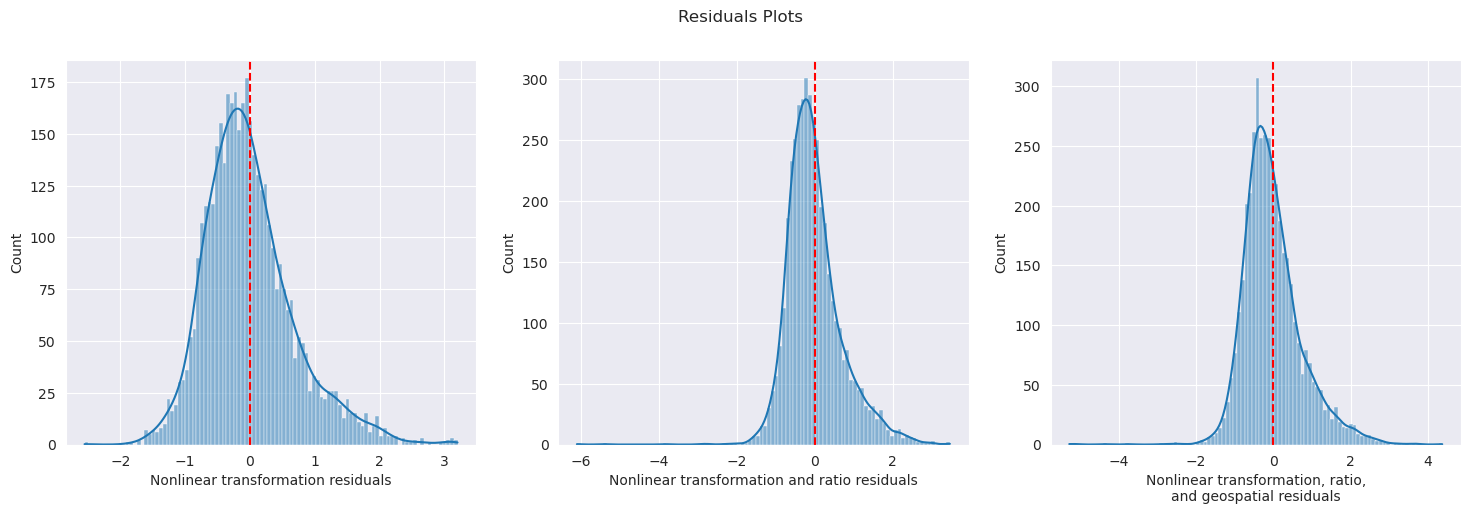

In [32]:
residuals_1 = clr_non_linear_transformation.get_residuals()
residuals_2 = clr_non_linear_transformation_and_ratio.get_residuals()
residuals_3 = clr_non_linear_transformation_and_ratio_geo_spatial.get_residuals()
 
figure, axes = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18, 5)

sns.histplot(residuals_1, ax=axes[0], bins=100, kde=True)
axes[0].set_xlabel('Nonlinear transformation residuals')
axes[0].axvline(x=0, color='red', linestyle='--')

sns.histplot(residuals_2, ax=axes[1], bins=100, kde=True)
axes[1].set_xlabel('Nonlinear transformation and ratio residuals')
axes[1].axvline(x=0, color='red', linestyle='--')

sns.histplot(residuals_3, ax=axes[2], bins=100, kde=True)
axes[2].set_xlabel('Nonlinear transformation, ratio,\nand geospatial residuals');
axes[2].axvline(x=0, color='red', linestyle='--')

figure.suptitle('Residuals Plots');

In [33]:
# import scipy.stats as stats

# # for residual in [residuals_1, residuals_2, residuals_3]:
# #     plt.figure()
# #     ax = stats.probplot(ratio_nonlinear_geospatial_copy.Log_Population, dist="norm", plot=plt)
# #     plt.title("Q-Q Plot of Residuals")
# # plt.show()

# clr_base.plot_residuals()
# clr_non_linear_transformation.plot_residuals()
# clr_non_linear_transformation_and_ratio.plot_residuals()
# clr_non_linear_transformation_and_ratio_geo_spatial.plot_residuals()

#
---
---
---
---

In [34]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(cali_housing_samples, cali_housing_targets, test_size=0.2, random_state=100, shuffle=True)

decision_tree = DecisionTreeRegressor(
    max_features='sqrt',
    criterion='squared_error',

    # These parameters led to overfit (very low training mse 0.03 and higher testing mse 0.21)

    # max_depth=best_params['max_depth'],
    # min_samples_leaf=best_params['min_samples_leaf'],
    # min_samples_split=best_params['min_samples_split'],

    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=3,

)

decision_tree.fit(X_train.astype(np.float64), y_train.astype(np.float64))

testing_predictions = decision_tree.predict(X_test)
training_predictions = decision_tree.predict(X_train)

print(decision_tree.get_params())

print(f'\n\nTraining R2 score: {r2_score(y_train, training_predictions):.2f}')
print(f'Testing R2 score:  {r2_score(y_test, testing_predictions):.2f}')

print(f'\nTraining mse:  {mean_squared_error(y_train, training_predictions):.2f}')
print(f'Testing mse: {mean_squared_error(y_test, testing_predictions):.2f}')

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


Training R2 score: 0.77
Testing R2 score:  0.68

Training mse:  0.30
Testing mse: 0.43


            Importance
MedInc        0.622884
Longitude     0.108559
Latitude      0.094109
AveOccup      0.086014
AveRooms      0.036765
HouseAge      0.026813
Population    0.015302
AveBedrms     0.009554


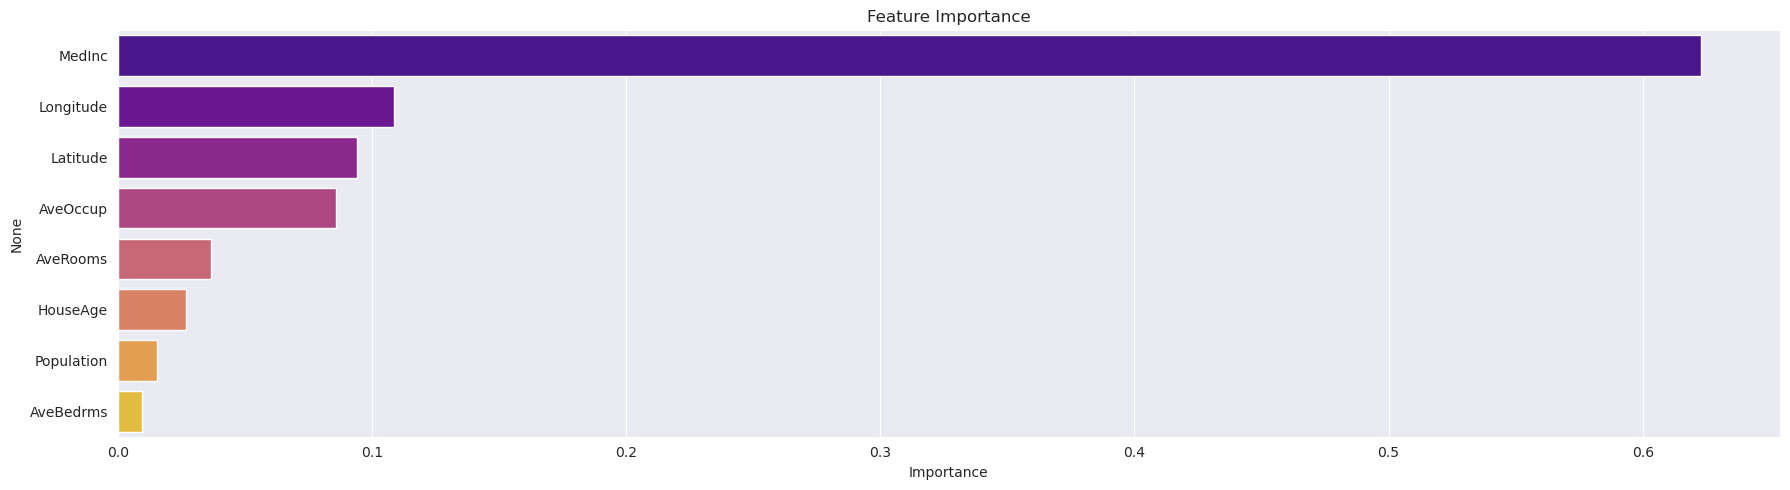

In [35]:
importance_df = pd.DataFrame(data={'Importance': decision_tree.feature_importances_}, index=decision_tree.feature_names_in_).sort_values(by='Importance', ascending=False)
print(importance_df)

plt.figure(figsize=(18, 5))
plt.title('Feature Importance')
sns.barplot(y=importance_df.index, x=importance_df.Importance, palette='plasma')
plt.tight_layout()